In [10]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import *
import sys
import librosa
import time
#import IPython.display as ipd
import simpleaudio as sa

def plotaudio(y):
    plt.plot(y)
    plt.show()

def plot2im ( y ):
    fig=plt.figure()
    plt.plot(y)
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( h, w,4 )
    #get only BGR (opencv pattern)
    buf=buf[:,:,[3,2,1]]

    return buf

def nothing(val):
    pass
def viewFrame(num):
    if not play:
        cap.set(cv2.CAP_PROP_POS_FRAMES, num)
        ret, frame = cap.read()
        cv2.imshow('video',frame)

import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import *
import sys
import librosa
import time
from scipy.signal import medfilt
import simpleaudio as sa
import pandas as pd
import crepe
from scipy.io import wavfile

def video_note_split(vName,threshold=0.8, tune_thresh=0.3,dur_thresh=0.1):
    """
    vName: string ending with .mp4 that contains the video with the notes
    creates a csv file cointaining the starting and ending of all notes
    """
    
    video = VideoFileClip(vName)
    audio = video.audio
    h,w=video.size
    fps=video.fps
    print('video size ',w,'x',h,', at ',fps,' fps.')
    t=audio.duration
    sr=audio.fps
    print('audio duration: ',t,', sampling rate: ',sr)
    y=audio.to_soundarray(fps=sr)
    filename = librosa.util.example_audio_file()

    y=librosa.core.to_mono(np.transpose(y))
    #y_harmonic, y_percussive = librosa.effects.hpss(y)
    time, frequency, confidence, activation = crepe.predict(y, sr, viterbi=True)
    mfr=medfilt(frequency,21)
    midi=69+12*np.log2(mfr/440)
    mcon=medfilt(confidence,21)
    plt.plot(time,midi)
    plt.plot(time,np.min(midi)+mcon*(np.max(midi)-np.min(midi)))
    plt.show()

    registeringNote=False
    notas = {'midi':[],'inicio':[],'fim':[],'duracao':[],'i':[],'j':[],'avg conf':[],'std dev':[]}
    notas = pd.DataFrame(notas)
    for i in range(time.shape[0]):
        if confidence[i]>threshold:
            if not registeringNote:
                registeringNote=True
                row=pd.DataFrame({'midi':[midi[i]],'inicio':[time[i]],'i':[i]})            
                notas=notas.append(row, ignore_index=True)
            else:
                pass
        else:
            if registeringNote:
                registeringNote=False
                notas.at[notas.index[-1],'j']=i
                notas.at[notas.index[-1],'fim']=time[i]
                notas.at[notas.index[-1],'duracao']=notas.at[notas.index[-1],'fim']-notas.at[notas.index[-1],'inicio']
                notas.at[notas.index[-1],'avg conf']=np.average(confidence[int(notas.at[notas.index[-1],'i']):i])
                #print(notas.tail(1))
                #note end
            else:
                pass
    #remove low duration notes
    indexLowDur = notas[ notas['duracao'] < dur_thresh ].index
    notas=notas.drop(indexLowDur , inplace=False)
    #remove out of tune notes
    for index, row in notas.iterrows():
        i=int(notas.at[index,'i'])
        j=int(notas.at[index,'j'])
        note=int(round(np.average(midi[i:j])))
        std = np.sqrt(np.average(abs(midi[i:j] - note)**2))#std deviation
        #print(np.abs(midi[i:j]-note)<tuneThresh)
        notesThatPassed=np.abs(midi[i:j]-note)<tune_thresh
        if not all(notesThatPassed):
            #remove that line         
            notas=notas.drop(index , inplace=False)
        else:
            notas.at[index,'midi']=note
            notas.at[index,'std dev']=std
    
    print("identifyed notes: ")
    print(notas)
    vName=vName.split('.')[0]
    notas.to_csv(vName+'.csv', index = False)
    return notas



from mido import MidiFile
import mido
import time

def read_midi_tracks(filename,track_num=0):
    """
    filename: string .mid
    track_num: number of the track, if 0, return all tracks
    creates and returns a song structure, with midi notes, start time and duration
    """
    song=[]
    mid = MidiFile(filename)
    if mid.type==1:
        for i, track in enumerate(mid.tracks):
            print('Track {}: {}'.format(i, track.name))        
            midiNotes=list()#[len(mid.tracks)][]
            startTimes=list()
            endTimes=list() 
            mi=0
            cumulative_time=0
            for msg in track:            
                if not msg.is_meta:                
                    if msg.type=='note_on':
                        midiNotes.append(msg.note)
                        startTimes.append(cumulative_time)
                        cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))                
                        endTimes.append(cumulative_time)
                        mi+=1
                    else:    
                        cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))                
            song.append({'midi':midiNotes,'start':startTimes,'end':endTimes})
    if track_num==0:
        print('returning all tracks')
        return song
    else:
        print('returning track '+str(track_num))
        return song[track_num]

import subprocess as sp
from moviepy.editor import *
import os

def create_clip(source_file,notes_file,song_midi,save_name):
    """
    Source file: video(.mp4) from where i take the notes
    notas: csv with information of the notes of a source video, generated by func
    song_midi: list of midi notes, generated by func
    save_name: .mp4 string with the name to save the file
    create the file with the sequenced song
    """
    notas=pd.read_csv(notes_file)
    source_vid=VideoFileClip(source_file)

    clips=[]
    for i in range(len(song_midi['midi'])):
        this_note=notas.loc[notas['midi'] == song_midi['midi'][i]]#select with correct midi value
        
        if len(this_note)==0:
            print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
            continue
        dur=song_midi['end'][i]-song_midi['start'][i]
        this_note=this_note.loc[this_note['duracao'] >= dur]#select with the right duration
        if len(this_note)==0:
            print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
            continue
        this_note=this_note[this_note['std dev'] == this_note['std dev'].min()]#nota mais afinada 
        if len(this_note)==0:
            print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
            continue
        print("adding note: ")
        print(this_note)
        startime=this_note.at[this_note.index[-1],'inicio']
        endtime=startime+dur 
        noteClip=source_vid.subclip(startime,endtime)#this_note['inicio'],this_note['inicio']+dur)
        noteClip=noteClip.set_start(song_midi['start'][i])
        clips.append(noteClip)


    cc = CompositeVideoClip(clips)
    cc.write_videofile(save_name)


video size  1080 x 1920 , at  29.97002997002997  fps.
audio duration:  8.21 , sampling rate:  44100
822/822 [==============================] - 92s 112ms/step


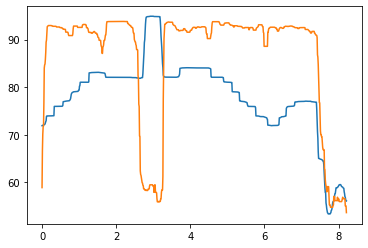

identifyed notes: 
    avg conf  duracao   fim      i  inicio      j  midi   std dev
1   0.949951     0.18  0.31   13.0    0.13   31.0  74.0  0.044362
2   0.935561     0.22  0.56   34.0    0.34   56.0  76.0  0.036260
3   0.930249     0.15  0.73   58.0    0.58   73.0  77.0  0.071736
4   0.947788     0.15  0.98   83.0    0.83   98.0  79.0  0.068348
5   0.953305     0.19  1.23  104.0    1.04  123.0  81.0  0.026990
6   0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
9   0.967436     0.72  2.45  173.0    1.73  245.0  82.0  0.067877
13  0.953701     0.38  3.67  329.0    3.29  367.0  82.0  0.092840
14  0.931831     0.73  4.46  373.0    3.73  446.0  84.0  0.056203
16  0.962519     0.32  4.89  457.0    4.57  489.0  82.0  0.071641
17  0.946988     0.21  5.12  491.0    4.91  512.0  81.0  0.049260
18  0.941614     0.19  5.32  513.0    5.13  532.0  79.0  0.040571
19  0.936775     0.17  5.52  535.0    5.35  552.0  77.0  0.082518
20  0.932094     0.20  5.75  555.0    5.55  575.0  76.0  

,avg conf,duracao,fim,i,inicio,j,midi,std dev
1,0.949951,0.18,0.31,13.0,0.13,31.0,74.0,0.044362
2,0.935561,0.22,0.56,34.0,0.34,56.0,76.0,0.036260
3,0.930249,0.15,0.73,58.0,0.58,73.0,77.0,0.071736
4,0.947788,0.15,0.98,83.0,0.83,98.0,79.0,0.068348
5,0.953305,0.19,1.23,104.0,1.04,123.0,81.0,0.026990
6,0.916911,0.25,1.53,128.0,1.28,153.0,83.0,0.081179
9,0.967436,0.72,2.45,173.0,1.73,245.0,82.0,0.067877
13,0.953701,0.38,3.67,329.0,3.29,367.0,82.0,0.092840
14,0.931831,0.73,4.46,373.0,3.73,446.0,84.0,0.056203
16,0.962519,0.32,4.89,457.0,4.57,489.0,82.0,0.071641


In [11]:
video_note_split('flauta.mp4')

In [12]:
notas=read_midi_tracks('bach_badinerie.mid',track_num=1)

Track 0: J.S.Bach
Track 1: Flute
Track 2: Piano
returning track 1


In [13]:
create_clip('flauta.mp4','flauta.csv',notas,'bach.mp4')

adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
missing note of midi 86, and duration of at least 0.1171875
missing note of midi 86, and duration of at least 0.1171875
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   f

adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
missing note of midi 73, a

adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
missing note of midi 85, and duration of at least 0.05859375
missing note of midi 85, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi  std dev
4  0.953305     0.19  1.23  104.0    1.04  123.0  81.0  0.02699
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi  std dev
4  0.953305     0.19  1.23  104.0    1.04  123.0  81.0  0.02699
missing note of midi 80, and duration of at least 0.05859375
missing note of midi 80, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi  std dev
4  0.953305     0.19  1.23  104.0    1.04  123.0  81.0  0.02699
adding note: 
   avg conf  duracao   fim      i  inicio      j  

adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg

adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
2  0.930249     0.15  0.73  58.0    0.58  73.0  77.0  0.071736
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 85, and duration of at least 0.05859375
missing note of midi 85, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
2  0.930249     0.15  0.73  58.0    0.58  73.0  77.0  0.071736
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
2  0.930249     0.15  0.73  58.0    0.58  73.0  77.0  0.071736
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 86, and duration of at least 0.05859375
missing note of midi 86, and du

adding note: 
    avg conf  duracao   fim      i  inicio      j  midi   std dev
11  0.941614     0.19  5.32  513.0    5.13  532.0  79.0  0.040571
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
    avg conf  duracao   fim      i  inicio      j  midi   std dev
11  0.941614     0.19  5.32  513.0    5.13  532.0  79.0  0.040571
adding note: 
    avg conf  duracao   fim      i  inicio      j  midi   std dev
11  0.941614     0.19  5.32  513.0    5.13  532.0  79.0  0.040571
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
missing no

adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
missing note of midi 73, and duration of at least 0.05859375
missing note of midi 73, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  dur

1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
missing note of midi 78, and duration of at least 0.02197265625
missing note of midi 78, and duration of at least 0.02197265625
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
missing note of midi 78, and duration of at least 0.018310546875
missing note of midi 78, and duration of at least 0.018310546875
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0

adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
missing note of midi 78, and duration of at least 0.1171875
missing note of midi 78, and duration of at least 0.1171875
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inic

   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
missing note of midi 73, and duration of

adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
missing note of midi 78, and duration of at least 0.02197265625
missing note of midi 78, and duration of at least 0.02197265625
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
1  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
missing note of midi 78, and duration of at least 0.018310

adding note: 
   avg conf  duracao   fim      i  inicio      j  midi  std dev
4  0.953305     0.19  1.23  104.0    1.04  123.0  81.0  0.02699
adding note: 
    avg conf  duracao   fim      i  inicio      j  midi   std dev
11  0.941614     0.19  5.32  513.0    5.13  532.0  79.0  0.040571
missing note of midi 79, and duration of at least 0.3515625
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
5  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi  std dev
4  0.953305     0.19  1.23  104.0    1.04  123.0  81.0  0.02699
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi  std dev
4  0.953305     0.19  1.23  104.0    1.04  123.0  81.0  0.02699
adding note: 
    avg conf  duracao   fim      i  inicio      j  midi   std dev


adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
missing note of midi 73, and duration of at least 0.05859375
missing note of midi 73, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
0  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
missing note of midi 73, and duration of at least 0.0421142578125
missing note of midi 73, and duration of at least 0.0421142578125
missing note of midi 71, and duration of at least 0.0421142578125
missing note of midi 71, and duration of at least 0.0421142578125


chunk:   1%|          | 6/832 [00:00<00:13, 59.79it/s, now=None]

Moviepy - Building video bach.mp4.
MoviePy - Writing audio in bachTEMP_MPY_wvf_snd.mp3


t:   0%|          | 0/1131 [00:00<?, ?it/s, now=None]             

MoviePy - Done.
Moviepy - Writing video bach.mp4



Moviepy - Done !
Moviepy - video ready bach.mp4


In [2]:
vName='flauta.mp4'

video = VideoFileClip(vName)
audio = video.audio
h,w=video.size
fps=video.fps
print('video size ',w,'x',h,', at ',fps,' fps.')
t=audio.duration
sr=audio.fps
print('audio duration: ',t,', sampling rate: ',sr)
audio.write_audiofile("audio.mp3")
y=audio.to_soundarray(fps=sr)
filename = librosa.util.example_audio_file()

# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
#y, sr = librosa.load(filename)
y=librosa.core.to_mono(np.transpose(y))
#y_harmonic, y_percussive = librosa.effects.hpss(y)


chunk:  20%|█▉        | 36/182 [00:00<00:00, 244.75it/s, now=None]

video size  1080 x 1920 , at  29.97002997002997  fps.
audio duration:  8.21 , sampling rate:  44100
MoviePy - Writing audio in audio.mp3


MoviePy - Done.


In [3]:

time, frequency, confidence, activation = crepe.predict(y, sr, viterbi=True)



822/822 [==============================] - 91s 111ms/step


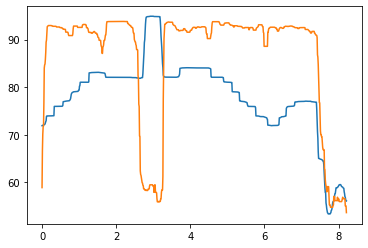

Empty DataFrame
Columns: [midi, inicio, fim, duracao, i, j, avg conf, std dev]
Index: []
    avg conf  duracao   fim      i  inicio      j       midi  std dev
0   0.855108     0.03  0.09    6.0    0.06    9.0  72.090291      NaN
1   0.949951     0.18  0.31   13.0    0.13   31.0  73.927433      NaN
2   0.935561     0.22  0.56   34.0    0.34   56.0  75.955967      NaN
3   0.930249     0.15  0.73   58.0    0.58   73.0  76.951484      NaN
4   0.947788     0.15  0.98   83.0    0.83   98.0  78.914295      NaN
5   0.953305     0.19  1.23  104.0    1.04  123.0  81.030031      NaN
6   0.916911     0.25  1.53  128.0    1.28  153.0  82.992062      NaN
7   0.864611     0.03  1.59  156.0    1.56  159.0  83.085643      NaN
8   0.864605     0.08  1.71  163.0    1.63  171.0  83.012449      NaN
9   0.967436     0.72  2.45  173.0    1.73  245.0  82.071950      NaN
10  0.902268     0.09  2.56  247.0    2.47  256.0  81.992970      NaN
11  0.837277     0.03  2.62  259.0    2.59  262.0  81.930450      NaN
1

In [4]:
import matplotlib.pyplot as plt
from scipy.signal import medfilt
mfr=medfilt(frequency,21)
midi=69+12*np.log2(mfr/440)
mcon=medfilt(confidence,21)
plt.plot(time,midi)
plt.plot(time,np.min(midi)+mcon*(np.max(midi)-np.min(midi)))
plt.show()

import pandas as pd
threshold=0.8
tune_thresh=0.3#in midi
registeringNote=False
notas = {'midi':[],'inicio':[],'fim':[],'duracao':[],'i':[],'j':[],'avg conf':[],'std dev':[]}
notas = pd.DataFrame(notas)
print(notas)
for i in range(time.shape[0]):
    if confidence[i]>threshold:
        if not registeringNote:
            registeringNote=True
            row=pd.DataFrame({'midi':[midi[i]],'inicio':[time[i]],'i':[i]})            
            #print(row)
            notas=notas.append(row, ignore_index=True)
            #print(notas.tail(1))

            #note start
        else:
            pass
    else:
        if registeringNote:
            registeringNote=False
            notas.at[notas.index[-1],'j']=i
            notas.at[notas.index[-1],'fim']=time[i]
            notas.at[notas.index[-1],'duracao']=notas.at[notas.index[-1],'fim']-notas.at[notas.index[-1],'inicio']
            notas.at[notas.index[-1],'avg conf']=np.average(confidence[int(notas.at[notas.index[-1],'i']):i])
            #print(notas.tail(1))
            #note end
        else:
            pass
print(notas)
#demove low duration notes
durThresh=0.1
indexLowDur = notas[ notas['duracao'] < durThresh ].index
notas=notas.drop(indexLowDur , inplace=False)
print(notas)
#remove out of tune notes
tuneThresh=0.3
for index, row in notas.iterrows():
    i=int(notas.at[index,'i'])
    j=int(notas.at[index,'j'])
    note=int(round(np.average(midi[i:j])))
    std = np.sqrt(np.average(abs(midi[i:j] - note)**2))#std deviation
    #print(np.abs(midi[i:j]-note)<tuneThresh)
    notesThatPassed=np.abs(midi[i:j]-note)<tuneThresh
    if not all(notesThatPassed):
        #remove that line         
        notas=notas.drop(index , inplace=False)
    else:
        notas.at[index,'midi']=note
        notas.at[index,'std dev']=std

print(notas)
notas.to_csv(r'flauta.csv', index = False)


In [ ]:
!pip install moviepy --upgrade
import subprocess as sp
from moviepy.editor import *
import os
recorder = VideoFileClip("flauta.mp4")

song_midi={'midi':[72, 72, 74, 72, 77, 76, 60],'start':[0.0,0.05,0.1,0.3,0.4,0.5,0.7],'end':[0.05,0.1,0.3,0.4,0.5,0.7,0.8]}
#song_midi={'midi':[60, 60, 62, 60, 65, 64],'start':[0.0,0.05,0.1,0.3,0.4,0.5],'end':[0.05,0.1,0.3,0.4,0.5,0.7]}


clips=[]
for i in range(len(song_midi['midi'])):
    this_note=notas.loc[notas['midi'] == song_midi['midi'][i]]#select with correct midi value
    ok=False
    if len(this_note)>0:
        ok=True
    dur=song_midi['end'][i]-song_midi['start'][i]
    this_note=this_note.loc[this_note['duracao'] >= dur]#select with the right duration
    if len(this_note)>0:
        ok=True
    this_note=this_note[this_note['std dev'] == this_note['std dev'].min()]#nota mais afinada 
    if len(this_note)>0:
        ok=True
    if not ok:
        print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
        continue
    startime=this_note.at[this_note.index[-1],'inicio']
    endtime=startime+dur 
    noteClip=recorder.subclip(startime,endtime)#this_note['inicio'],this_note['inicio']+dur)
    noteClip=noteClip.set_start(song_midi['start'][i])
    clips.append(noteClip)
    print("adding note: ")
    print(this_note)

cc = CompositeVideoClip(clips)
cc.write_gif("test.gif")
#cc.set_duration(0.5).write_videofile("happytest.mp4")
cc.write_videofile("happytest.mp4")





In [5]:

from mido import MidiFile
import mido
import time
mid = MidiFile('bach_badinerie.mid')
print(len(mid.tracks))
song=[]
print(mid)
print(mid.ticks_per_beat)
if mid.type==1:
    for i, track in enumerate(mid.tracks):
        print('Track {}: {}'.format(i, track.name))        
        midiNotes=list()#[len(mid.tracks)][]
        startTimes=list()
        endTimes=list() 
        mi=0
        cumulative_time=0
        for msg in track:            
            if not msg.is_meta:                
                if msg.type=='note_on':
                    midiNotes.append(msg.note)
                    startTimes.append(cumulative_time)
                    cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))                
                    endTimes.append(cumulative_time)
                    mi+=1
                else:    
                    cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))                
        song.append({'midi':midiNotes,'start':startTimes,'end':endTimes})
#print(song)
#print(song[1]['midi'][0])
print(song[1])


3
<midi file 'bach_badinerie.mid' type 1, 3 tracks, 2844 messages>
256
Track 0: J.S.Bach
Track 1: Flute
Track 2: Piano
{'midi': [83, 83, 86, 86, 83, 83, 78, 78, 83, 83, 78, 78, 74, 74, 78, 78, 74, 74, 71, 71, 66, 66, 71, 71, 74, 74, 71, 71, 73, 73, 71, 71, 73, 73, 71, 71, 70, 70, 73, 73, 76, 76, 73, 73, 74, 74, 71, 71, 83, 83, 86, 86, 83, 83, 78, 78, 83, 83, 78, 78, 74, 74, 78, 78, 74, 74, 71, 71, 74, 74, 73, 73, 74, 74, 74, 74, 73, 73, 74, 74, 83, 83, 74, 74, 74, 74, 76, 76, 74, 74, 76, 76, 74, 74, 73, 73, 78, 78, 77, 77, 78, 78, 78, 78, 77, 77, 78, 78, 86, 86, 78, 78, 78, 78, 80, 80, 78, 78, 80, 80, 78, 78, 77, 77, 73, 73, 78, 78, 81, 81, 78, 78, 80, 80, 78, 78, 80, 80, 78, 78, 77, 77, 80, 80, 83, 83, 80, 80, 81, 81, 80, 80, 81, 81, 80, 80, 78, 78, 81, 81, 78, 78, 77, 77, 78, 78, 83, 83, 78, 78, 77, 77, 78, 78, 85, 85, 78, 78, 77, 77, 78, 78, 86, 86, 78, 78, 77, 77, 78, 78, 86, 86, 85, 85, 83, 83, 85, 85, 81, 81, 80, 80, 78, 78, 81, 81, 80, 80, 81, 81, 80, 80, 81, 81, 80, 80, 78, 78,

In [7]:
import subprocess as sp
from moviepy.editor import *
import os
recorder = VideoFileClip("flauta.mp4")
song_midi=song[1]

clips=[]
for i in range(len(song_midi['midi'])//2):
    this_note=notas.loc[notas['midi'] == song_midi['midi'][i]]#select with correct midi value
    ok=False
    if len(this_note)==0:
        print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
        continue
    dur=song_midi['end'][i]-song_midi['start'][i]
    this_note=this_note.loc[this_note['duracao'] >= dur]#select with the right duration
    if len(this_note)==0:
        print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
        continue
    this_note=this_note[this_note['std dev'] == this_note['std dev'].min()]#nota mais afinada 
    if len(this_note)==0:
        print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
        continue
    print("adding note: ")
    print(this_note)
    startime=this_note.at[this_note.index[-1],'inicio']
    endtime=startime+dur 
    #recorder.write_videofile('test.mp4')
    noteClip=recorder.subclip(startime,endtime)#this_note['inicio'],this_note['inicio']+dur)
    noteClip=noteClip.set_start(song_midi['start'][i])
    clips.append(noteClip)
    

cc = CompositeVideoClip(clips)
#cc.write_gif("test.gif")
#cc.set_duration(0.5).write_videofile("happytest.mp4")
cc.write_videofile("bach.mp4")


adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
6  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
6  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
missing note of midi 86, and duration of at least 0.1171875
missing note of midi 86, and duration of at least 0.1171875
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
6  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
6  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
6  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   f

adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
2  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
1  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
1  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
2  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
2  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
1  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
1  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
missing note of midi 73, a

adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
6  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
missing note of midi 85, and duration of at least 0.05859375
missing note of midi 85, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi  std dev
5  0.953305     0.19  1.23  104.0    1.04  123.0  81.0  0.02699
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi  std dev
5  0.953305     0.19  1.23  104.0    1.04  123.0  81.0  0.02699
missing note of midi 80, and duration of at least 0.05859375
missing note of midi 80, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi  std dev
5  0.953305     0.19  1.23  104.0    1.04  123.0  81.0  0.02699
adding note: 
   avg conf  duracao   fim      i  inicio      j  

   avg conf  duracao   fim      i  inicio      j  midi   std dev
6  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   fim      i  inicio      j  midi   std dev
6  0.916911     0.25  1.53  128.0    1.28  153.0  83.0  0.081179
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
1  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
1  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
1  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
1  0.949951     0.18  0.31  13.0    0.13  31.0  74.0  0.044362
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
2  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  d

adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
3  0.930249     0.15  0.73  58.0    0.58  73.0  77.0  0.071736
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 85, and duration of at least 0.05859375
missing note of midi 85, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
3  0.930249     0.15  0.73  58.0    0.58  73.0  77.0  0.071736
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi   std dev
3  0.930249     0.15  0.73  58.0    0.58  73.0  77.0  0.071736
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 86, and duration of at least 0.05859375
missing note of midi 86, and du

adding note: 
    avg conf  duracao   fim      i  inicio      j  midi   std dev
18  0.941614     0.19  5.32  513.0    5.13  532.0  79.0  0.040571
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
2  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
2  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
    avg conf  duracao   fim      i  inicio      j  midi   std dev
18  0.941614     0.19  5.32  513.0    5.13  532.0  79.0  0.040571
adding note: 
    avg conf  duracao   fim      i  inicio      j  midi   std dev
18  0.941614     0.19  5.32  513.0    5.13  532.0  79.0  0.040571
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
2  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
adding note: 
   avg conf  duracao   fim     i  inicio     j  midi  std dev
2  0.935561     0.22  0.56  34.0    0.34  56.0  76.0  0.03626
missing no

chunk:   2%|▏         | 8/417 [00:00<00:05, 79.30it/s, now=None]

Moviepy - Building video bach.mp4.
MoviePy - Writing audio in bachTEMP_MPY_wvf_snd.mp3


t:   0%|          | 0/566 [00:00<?, ?it/s, now=None]               

MoviePy - Done.
Moviepy - Writing video bach.mp4



Moviepy - Done !
Moviepy - video ready bach.mp4


In [ ]:

from mido import MidiFile
import mido
import time

def read_midi_tracks(filename,track_num=0):
    """
    filename: string .mid
    track_num: number of the track, if 0, return all tracks
    """
    mid = MidiFile(filename)
    if mid.type==1:
        for i, track in enumerate(mid.tracks):
            print('Track {}: {}'.format(i, track.name))        
            midiNotes=list()#[len(mid.tracks)][]
            startTimes=list()
            endTimes=list() 
            mi=0
            cumulative_time=0
            for msg in track:            
                if not msg.is_meta:                
                    if msg.type=='note_on':
                        midiNotes.append(msg.note)
                        startTimes.append(cumulative_time)
                        cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))                
                        endTimes.append(cumulative_time)
                        mi+=1
                    else:    
                        cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))                
            song.append({'midi':midiNotes,'start':startTimes,'end':endTimes})
    if track_num==0:
        return song
    else:
        return song[track_num]

import subprocess as sp
from moviepy.editor import *
import os

def create_clip(source_file,notas,song_midi,save_name):
    """
    Source file: video(.mp4) from where i take the notes
    notas: csv with information of the notes of a source video, generated by func
    midi: list of midi notes, generated by func
    save_name: .mp4 string with the name to save the file
    """
    source_vid=VideoFileClip(source_file)

    clips=[]
    for i in range(len(midi['midi'])//2):
        this_note=notas.loc[notas['midi'] == song_midi['midi'][i]]#select with correct midi value
        
        if len(this_note)==0:
            print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
            continue
        dur=song_midi['end'][i]-song_midi['start'][i]
        this_note=this_note.loc[this_note['duracao'] >= dur]#select with the right duration
        if len(this_note)==0:
            print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
            continue
        this_note=this_note[this_note['std dev'] == this_note['std dev'].min()]#nota mais afinada 
        if len(this_note)==0:
            print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
            continue
        print("adding note: ")
        print(this_note)
        startime=this_note.at[this_note.index[-1],'inicio']
        endtime=startime+dur 
        noteClip=source_vid.subclip(startime,endtime)#this_note['inicio'],this_note['inicio']+dur)
        noteClip=noteClip.set_start(song_midi['start'][i])
        clips.append(noteClip)


    cc = CompositeVideoClip(clips)
    cc.write_videofile(save_name)


In [ ]:

theCupSong = TextClip('Happy birthday',
    fontsize=50,
    font="Ubuntu-Regular",
    color = 'white')\
    .set_pos(('center', 0.24*H))
editedby = TextClip('Edited by Jonathan Alis',
    fontsize=28,
    font="Ubuntu-Regular",
    color = 'gray')\
    .set_pos(('center', 0.58*H))
titleScreen = CompositeVideoClip([theCupSong, editedby],
    size = (W,H))\
    .set_duration(3)\
    .fadeout(0.5)

print(midiNote)
port=mido.open_output()
for msg in mid:
    time.sleep(msg.time)
    if not msg.is_meta:
        port.send(msg)



In [ ]:
from moviepy.editor import *

# UKULELE CLIP, OBTAINED BY CUTTING AND CROPPING
# RAW FOOTAGE

ukulele = VideoFileClip("../../videos/moi_ukulele.MOV", audio=False).\
               subclip(60+33, 60+50).\
               crop(486, 180, 1196, 570)

w,h = moviesize = ukulele.size

# THE PIANO FOOTAGE IS DOWNSIZED, HAS A WHITE MARGIN, IS
# IN THE BOTTOM RIGHT CORNER 

piano = (VideoFileClip("../../videos/douceamb.mp4",audio=False).
         subclip(30,50).
         resize((w/3,h/3)).    # one third of the total screen
         margin( 6,color=(255,255,255)).  #white margin
         margin( bottom=20, right=20, opacity=0). # transparent
         set_pos(('right','bottom')) )



# A CLIP WITH A TEXT AND A BLACK SEMI-OPAQUE BACKGROUND

txt = TextClip("V. Zulkoninov - Ukulele Sonata", font='Amiri-regular',
	               color='white',fontsize=24)

txt_col = txt.on_color(size=(ukulele.w + txt.w,txt.h-10),
                  color=(0,0,0), pos=(6,'center'), col_opacity=0.6)


# THE TEXT CLIP IS ANIMATED.
# I am *NOT* explaining the formula, understands who can/want.
txt_mov = txt_col.set_pos( lambda t: (max(w/30,int(w-0.5*w*t)),
                                  max(5*h/6,int(100*t))) )



# FINAL ASSEMBLY
final = CompositeVideoClip([ukulele,txt_mov,piano])
final.subclip(0,5).write_videofile("../../ukulele.avi",fps=24,codec='libx264')




from moviepy.editor import VideoFileClip, clips_array, vfx
clip1 = VideoFileClip("myvideo.mp4").margin(10) # add 10px contour
clip2 = clip1.fx( vfx.mirror_x)
clip3 = clip1.fx( vfx.mirror_y)
clip4 = clip1.resize(0.60) # downsize 60%
final_clip = clips_array([[clip1, clip2],
                          [clip3, clip4]])
#final_clip.resize(width=480).write_videofile("my_stack.mp4")



import gizeh
import moviepy.editor as mpy

def make_frame(t):
    surface = gizeh.Surface(128,128) # width, height
    radius = W*(1+ (t*(2-t))**2 )/6 # the radius varies over time
    circle = gizeh.circle(radius, xy = (64,64), fill=(1,0,0))
    circle.draw(surface)
    return surface.get_npimage() # returns a 8-bit RGB array

clip = mpy.VideoClip(make_frame, duration=2) # 2 seconds
clip.write_gif("circle.gif",fps=15)